2/2 [==============================] - 1s 6ms/step
0 [D loss: 0.8933743238449097, acc.: 35.16] [G loss: 0.9958321452140808] [MSE: 0.9390338063862438]
1/1 [==============================] - 0s 230ms/step


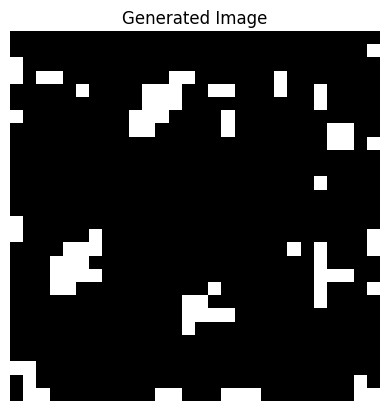

2/2 [==============================] - 0s 5ms/step
1000 [D loss: 0.6018284857273102, acc.: 70.31] [G loss: 1.0166747570037842] [MSE: 1.1293287100867258]
1/1 [==============================] - 0s 17ms/step


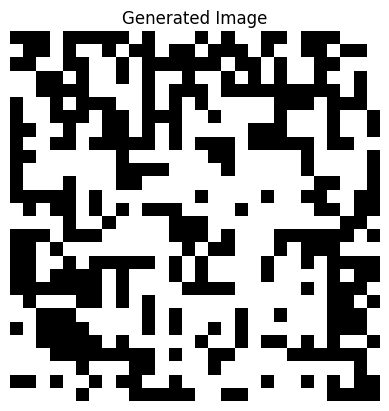

2/2 [==============================] - 0s 5ms/step
2000 [D loss: 0.5654870867729187, acc.: 75.00] [G loss: 1.1811246871948242] [MSE: 1.23341415681445]
1/1 [==============================] - 0s 17ms/step


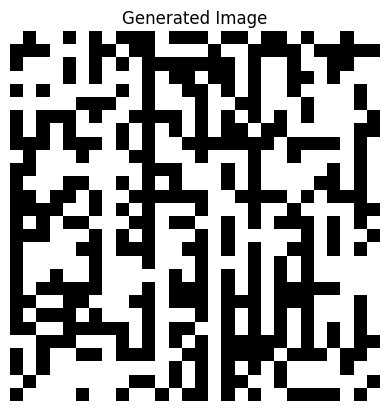

2/2 [==============================] - 0s 5ms/step
3000 [D loss: 0.5297922194004059, acc.: 78.91] [G loss: 1.2707747220993042] [MSE: 1.041916297052032]
1/1 [==============================] - 0s 18ms/step


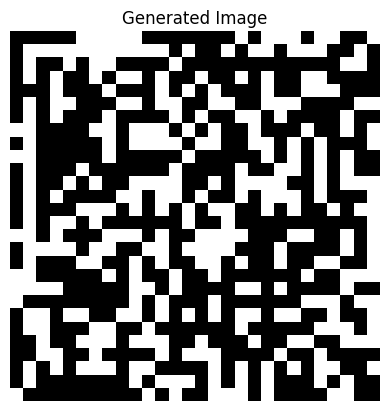

2/2 [==============================] - 0s 12ms/step
4000 [D loss: 0.5705994069576263, acc.: 74.22] [G loss: 1.3260031938552856] [MSE: 1.1183764507767031]
1/1 [==============================] - 0s 30ms/step


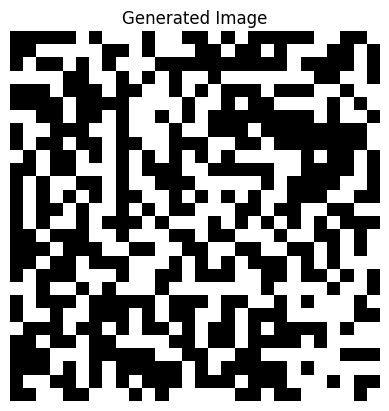

2/2 [==============================] - 0s 5ms/step
5000 [D loss: 0.5705812573432922, acc.: 74.22] [G loss: 1.355012059211731] [MSE: 1.243819490983865]
1/1 [==============================] - 0s 17ms/step


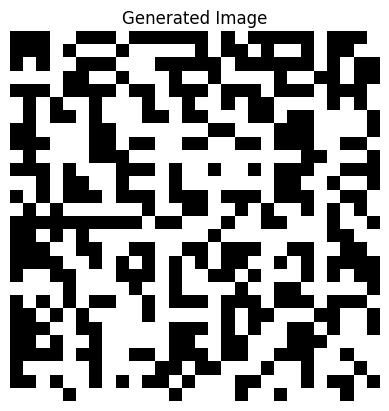

2/2 [==============================] - 0s 6ms/step
6000 [D loss: 0.5422051548957825, acc.: 76.56] [G loss: 1.3707609176635742] [MSE: 1.1414269162151982]
1/1 [==============================] - 0s 18ms/step


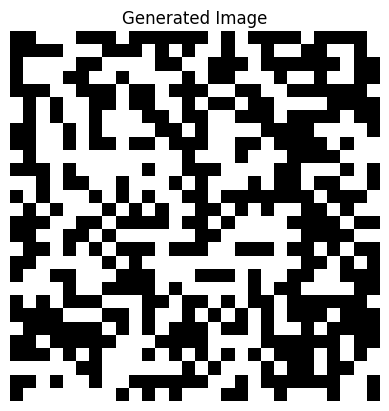

2/2 [==============================] - 0s 6ms/step
7000 [D loss: 0.6147987544536591, acc.: 69.53] [G loss: 1.3691458702087402] [MSE: 1.1262729585897733]
1/1 [==============================] - 0s 17ms/step


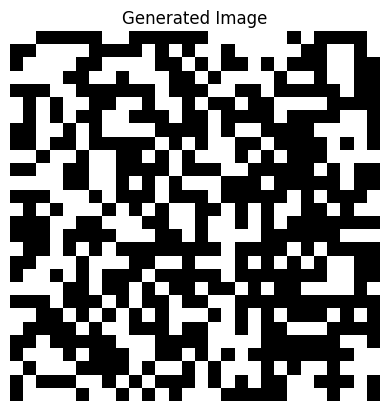

2/2 [==============================] - 0s 8ms/step
8000 [D loss: 0.5088640451431274, acc.: 79.69] [G loss: 1.3829329013824463] [MSE: 1.1247184597272373]
1/1 [==============================] - 0s 31ms/step


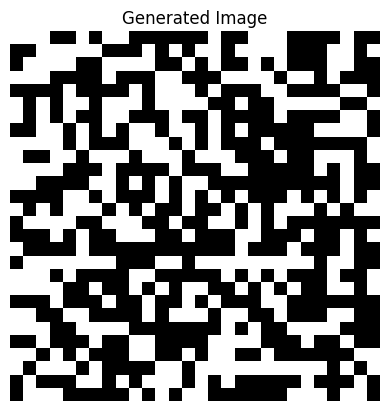

2/2 [==============================] - 0s 5ms/step
9000 [D loss: 0.6342322528362274, acc.: 68.75] [G loss: 1.3860700130462646] [MSE: 1.191958274408588]
1/1 [==============================] - 0s 17ms/step


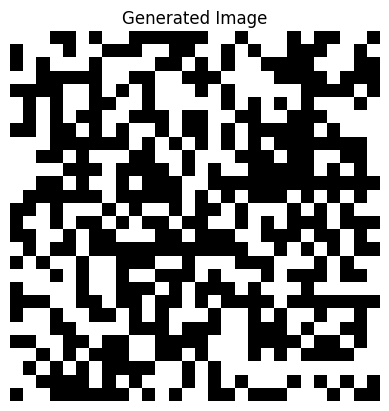

2/2 [==============================] - 0s 6ms/step


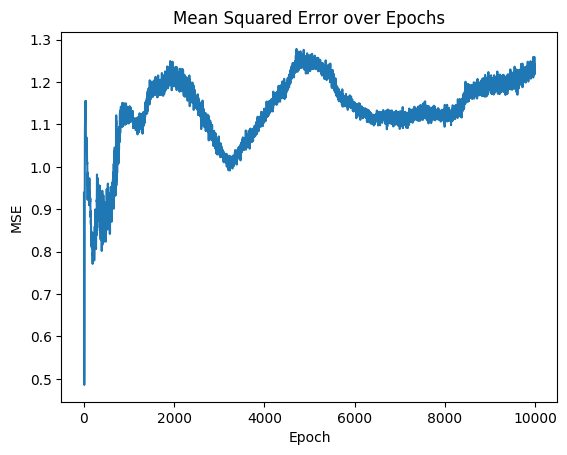

1/1 [==============================] - 0s 108ms/step


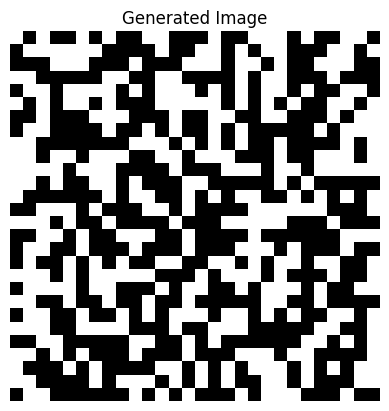

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

# Define the generator architecture
def build_generator(noise_shape, reflectance_shape):
    model = Sequential()

    model.add(Dense(256 * 7 * 7, activation="relu", input_shape=(noise_shape[0] + reflectance_shape[0],)))
    model.add(Reshape((7, 7, 256)))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=noise_shape)
    reflectance = Input(shape=reflectance_shape)
    gen_input = Concatenate()([noise, reflectance])

    img = model(gen_input)

    return Model([noise, reflectance], img)

# Define the discriminator architecture
def build_discriminator(img_shape, reflectance_shape):
    img = Input(shape=img_shape)
    reflectance = Input(shape=reflectance_shape)

    model = Conv2D(64, kernel_size=3, strides=2, padding="same")(img)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.25)(model)

    model = Conv2D(128, kernel_size=3, strides=2, padding="same")(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.25)(model)

    model = Conv2D(256, kernel_size=3, strides=2, padding="same")(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.25)(model)

    model = Conv2D(512, kernel_size=3, strides=2, padding="same")(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.25)(model)

    model = Flatten()(model)
    model_output = Dense(1, activation='sigmoid')(model)

    combined = Concatenate()([model_output, reflectance])
    validity = Dense(1, activation='sigmoid')(combined)

    return Model([img, reflectance], validity)

# Function to compile the CGAN
def compile_gan(generator, discriminator):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    discriminator.trainable = False

    noise_shape = generator.input[0].shape[1:]
    reflectance_shape = generator.input[1].shape[1:]
    noise = Input(shape=noise_shape)
    reflectance = Input(shape=reflectance_shape)
    img = generator([noise, reflectance])
    validity = discriminator([img, reflectance])

    combined = Model([noise, reflectance], validity)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return combined

# Training function
def train(epochs, batch_size, save_interval):
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    noise_shape = (100,)
    reflectance_shape = (100,)
    img_shape = X_train.shape[1:]
    generator = build_generator(noise_shape, reflectance_shape)
    discriminator = build_discriminator(img_shape, reflectance_shape)
    combined = compile_gan(generator, discriminator)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    mse_values = []

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_shape[0]))
        reflectance = np.random.normal(0, 1, (batch_size, reflectance_shape[0]))
        gen_imgs = generator.predict([noise, reflectance])

        real_smooth = real - 0.1 + (np.random.random(real.shape) * 0.2)
        flip_idx = np.random.choice([True, False], batch_size)
        real_flipped = real_smooth
        real_flipped[flip_idx] = fake[flip_idx]

        d_loss_real = discriminator.train_on_batch([imgs, reflectance], real_flipped)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, reflectance], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = combined.train_on_batch([noise, reflectance], real)

        mse = np.mean((imgs - gen_imgs) ** 2)
        mse_values.append(mse)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}] [G loss: {g_loss}] [MSE: {mse}]")
            generate_image(generator, noise_shape, reflectance_shape, f"generated_image_epoch_{epoch}.png")

    generator.save_weights("generator_weights.h5")

    plt.plot(mse_values)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error over Epochs')
    plt.show()

# Generate and save an image function
def generate_image(generator, noise_shape, reflectance_shape, filename="generated_image.png"):
    noise = np.random.normal(0, 1, (1, noise_shape[0]))
    reflectance = np.random.normal(0, 1, (1, reflectance_shape[0]))
    gen_img = generator.predict([noise, reflectance])
    gen_img = 0.5 * gen_img + 0.5  # Rescale to [0, 1]

    # Apply binary activation
    gen_img[gen_img >= 0.5] = 1
    gen_img[gen_img < 0.5] = 0

    plt.imshow(gen_img[0, :, :, 0], cmap='gray')
    plt.title("Generated Image")
    plt.axis('off')
    plt.savefig(filename)
    plt.show()

# Define shapes
noise_shape = (100,)
reflectance_shape = (100,)

# Training parameters
epochs = 10000
batch_size = 64
save_interval = 1000

# Train the model
train(epochs, batch_size, save_interval)

# Build and compile the generator
generator = build_generator(noise_shape, reflectance_shape)

# Load the weights of the trained generator
generator.load_weights("generator_weights.h5")

# Generate and show the final image
generate_image(generator, noise_shape, reflectance_shape)
